In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import time

In [2]:
# Load data
data = pd.read_csv(r"C:\Users\irola\Desktop\Dataset2\DogMoveData_csv_format_2\DogMoveData_merged_2.csv")

In [3]:
X = data.drop('Behavior', axis=1)
y = data['Behavior']
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Normalize the input features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split datasets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.3, random_state=42)

# Reshape input data for RNN
timesteps = 1
X_train_3d = X_train.reshape(-1, timesteps, X_train.shape[1])
X_test_3d = X_test.reshape(-1, timesteps, X_test.shape[1])

# One-hot encode target variable for RNN
y_train_onehot = to_categorical(y_train, num_classes)

# Define the advanced RNN model
def build_advanced_rnn(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(GRU(32, return_sequences=True))
    model.add(LSTM(16))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap RNN in KerasClassifier
rnn_model = KerasClassifier(
    build_fn=build_advanced_rnn,
    input_shape=(timesteps, X_train.shape[1]),
    num_classes=num_classes,
    epochs=10,
    batch_size=256,
    verbose=0
)

C:\Users\irola\AppData\Local\Temp\ipykernel_8640\1027915251.py:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasClassifier(


In [4]:
# Train RNN model separately and get predictions
rnn_model.fit(X_train_3d, y_train_onehot)
rnn_train_pred = rnn_model.predict(X_train_3d).reshape(-1, 1)
rnn_test_pred = rnn_model.predict(X_test_3d).reshape(-1, 1)

# Add RNN predictions to the feature sets for stacking
X_train_stacked = np.hstack([X_train, rnn_train_pred])
X_test_stacked = np.hstack([X_test, rnn_test_pred])


56586/56586 [==============================] - 132s 2ms/step


In [5]:
# Define optimized base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('naive_bayes', GaussianNB()),
    ('gradient_boosting', HistGradientBoostingClassifier(max_iter=50, random_state=42)),
]

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    cv=3
)

In [6]:
# Train the stacking classifier
start_time = time.time()
stacking_classifier.fit(X_train_stacked, y_train)
end_time = time.time()

# Make predictions and evaluate
y_pred = stacking_classifier.predict(X_test_stacked)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Elapsed Time:", end_time - start_time, "seconds")

C:\Users\irola\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9687539348901324
Elapsed Time: 666.680428981781 seconds


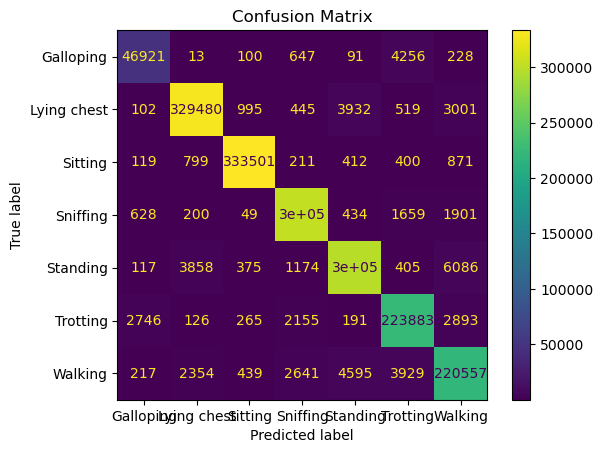

              precision    recall  f1-score   support

   Galloping       0.92      0.90      0.91     52256
 Lying chest       0.98      0.97      0.98    338474
     Sitting       0.99      0.99      0.99    336313
    Sniffing       0.98      0.98      0.98    307572
    Standing       0.97      0.96      0.96    309118
    Trotting       0.95      0.96      0.96    232259
     Walking       0.94      0.94      0.94    234732

    accuracy                           0.97   1810724
   macro avg       0.96      0.96      0.96   1810724
weighted avg       0.97      0.97      0.97   1810724



In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))